# XDS-Forces

Incorporate a scattering signal into the simulation using a harmonic $x^2$ potential:

$$
U_\mathrm{xds} = \frac{k_x}{2}x^2 
=
\sum_q \frac{k_x}{2\sigma^2_q} \left [
    S_\mathrm{exp}(q) - S_\mathrm{sim}(q)
\right ]^2,
$$


where $k_x$ is a user defined force constant, $\sigma_q$ is a weighing factor for each point, $S_\mathrm{exp}(q)$ is the experimentally measured signal, $S_\mathrm{sim}(q)$ is the simulated, and $\alpha$ the excitation fraction. In this test, the weighs will all be 1, and the fraction 1.

The force acting on atom $k$ derived from the simulated x-ray signal is then:

$$
\mathbf{F}_k = - \nabla_k U_\mathrm{xds}(S_\mathrm{sim})
$$

Apply the chain rule to get:

$$
\mathbf{F}_k = - \sum_q \frac{-\alpha}{\sigma^2_q} \left [
    S_\mathrm{exp}(q) - \alpha S_\mathrm{sim}(q) \right]  \nabla_k S_\mathrm{sim}(q)
$$

The simulated scattering is calculated via the Debye equation:  

$$
S_\mathrm{sim}(q) = \sum_i \sum_j f_i(q) f_j(q) \frac{\sin(q r_{ij})}{qr_{ij}},
$$

which should then be differentiated, which leads to an $\mathbf{r}$-dependent term, but is supposedly small, so the force expression in the end reduces to:  

$$
\mathbf{F}_k (q) = 2k_x \alpha \sum_q \frac{1}{\sigma_q^2}
\left[
    S_\mathrm{exp}(q) - \alpha S_\mathrm{sim}(q)
\right] \cdot
\sum_j \left [
    f_k(q) f_j(q) \left( \cos(q r_{kj}) - \frac{\sin(q r_{kj})}{q r_{kj}} \right) 
\right]
\frac{\mathbf{r}_{kj}}{r^2_{kj}}
$$



Ignoring excitation fractions for now:

$$
\mathbf{F}^{xds}_k (q) = 2k_x  \sum_q \frac{1}{\sigma_q^2}
\left[
    S_\mathrm{exp}(q) -  S_\mathrm{sim}(q)
\right] \cdot
\sum_j \left [
    f_k(q) f_j(q) \left( \cos(q r_{kj}) - \frac{\sin(q r_{kj})}{q r_{kj}} \right) 
\right]
\frac{\mathbf{r}_{kj}}{r^2_{kj}}
$$

For more info see 10.1063/5.0007158

In [1]:
%reset -f
%load_ext autoreload
%autoreload 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from ase import Atoms, units
from ase.io import Trajectory
from ase.constraints import Hookean
from ase.md.verlet import VelocityVerlet
from ase.md.nvtberendsen import NVTBerendsen

matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
plt.rcParams.update({'font.size': 14})
%matplotlib widget
       
# to make pretty colors for plot
def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors     

Import the XDS-based potential and forces, here implemented as an `ASE`-calculator: `DebyeCalc`

In [2]:
from xpot import DebyeCalc
from debye import Debye
from helpercalcs import DoubleCalc, SimpleBond

Let's test the shape of the potential by making a "Correct" model structure of two carbon atoms 1.5 Å apart, and calculating the scattering from those:

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


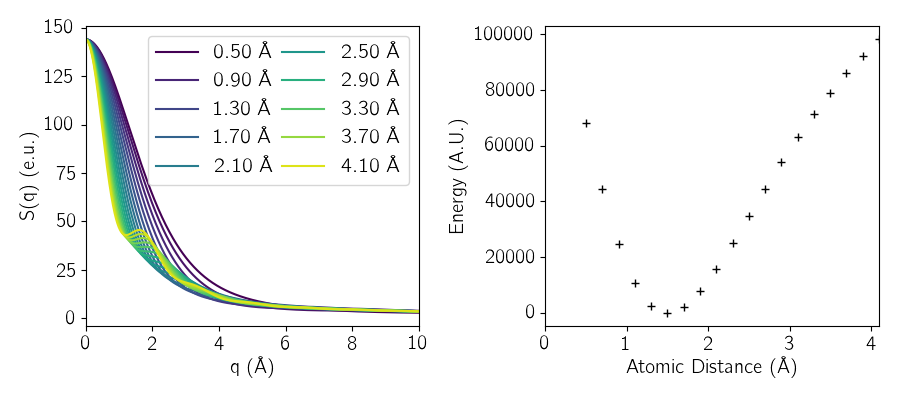

In [3]:
q = np.arange(0.0001, 10, 0.01)
xds = Debye(qvec=q)
xds_calc = DebyeCalc(xds)

atoms = Atoms('CC', positions=[[0, 0, -0.75], [0, 0, 0.75]])
s_exp = xds.debye(atoms)  # our 'experimental' signal

zs = np.arange(0.25, 2.10, 0.1)
col = make_colors(len(zs))

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for i, z in enumerate(zs):
    atoms = Atoms('CC', positions=[[0, 0, -1], [0, 0, 1]])
    atoms.positions = np.array([[0, 0, -z], 
                                [0, 0, z]])
    
    s = xds.debye_numba(atoms)

    dist = atoms.get_distance(0, 1)
    ax = axes[0]
    if i % 2 == 0:
        ax.plot(q, s, color=col[i], label=f'{dist:0.02f} Å')
    else:
        ax.plot(q, s, color=col[i])
    
    epot = xds_calc.xds_epot(atoms, s_exp)
    axes[1].plot(dist, epot, 'k+')


ax.set_xlim([0, 10])    
ax.set_xlabel('q (Å)')
ax.set_ylabel('S(q) (e.u.)')
ax.legend(loc='best', ncol=2, fontsize=15, columnspacing=0.4);

ax = axes[1]
ax.set_xlim([0, 4.1])    
#ax.set_ylim([-1e10, 4e11]);
ax.set_xlabel('Atomic Distance (Å)')
ax.set_ylabel('Energy (A.U.)')
plt.tight_layout()
plt.savefig('xds-pot.png', bbox_inches='tight')

The minimum energy is correctly found at 1.5 Å.

Lets use the XDS-forces to optimize a distorted version of diatomic model system back to the "true" geometry (1.5 Å) 

In [4]:
from ase.optimize import FIRE, BFGS

atoms = Atoms('CC', positions=[[0, 0, -0.75], [0, 0, 0.75]])
s_exp = Debye().debye(atoms)

atoms = Atoms('CC', positions=[[0, 0, -2], [0, 0, 2]])
atoms.calc = DebyeCalc(Debye(), s_exp, k=1e-8)

def get_dist(atoms=atoms):
    print(f'Current Distance: {atoms.get_distance(0, 1):6.5f} Å')

opt = BFGS(atoms, trajectory='first.traj')
opt.attach(get_dist)
opt.run(fmax=1e-7)
print(f'Optimized C-C distance: {atoms.get_distances(0, 1)[0]:6.5f} Å')

      Step     Time          Energy         fmax
BFGS:    0 17:25:22        0.000953        0.0003
Current Distance: 4.00000 Å
BFGS:    1 17:25:23        0.000953        0.0003
Current Distance: 3.99999 Å
BFGS:    2 17:25:23        0.000825        0.0003
Current Distance: 3.59999 Å
BFGS:    3 17:25:23        0.000672        0.0004
Current Distance: 3.19999 Å
BFGS:    4 17:25:23        0.000493        0.0005
Current Distance: 2.79999 Å
BFGS:    5 17:25:23        0.000298        0.0005
Current Distance: 2.39999 Å
BFGS:    6 17:25:23        0.000116        0.0004
Current Distance: 1.99999 Å
BFGS:    7 17:25:23        0.000006        0.0001
Current Distance: 1.59999 Å
BFGS:    8 17:25:23        0.000002        0.0001
Current Distance: 1.44445 Å
BFGS:    9 17:25:23        0.000000        0.0000
Current Distance: 1.50349 Å
BFGS:   10 17:25:24        0.000000        0.0000
Current Distance: 1.50011 Å
BFGS:   11 17:25:24        0.000000        0.0000
Current Distance: 1.50000 Å
Optimized C-C d

The XDS-forces correctly push the atoms back in the geometry we defined as the correct geometry. 

Let us assess the forces over a dynamics trajectory, standing in for many different configurations of photosensitizer molecules.

In [5]:
#### First make the 'target' dynamics
dt = 0.2

# Make diatomic Atoms object
atoms = Atoms('CC', positions=np.array([[-1, 0, 0], [1, 0, 0]]))

# Set simple Hookean calculator with x0 = 1.5 Ang.
k = 500 * units.kJ / units.mol
atoms.calc = SimpleBond([[0, 1]],  # list of atom-indices to put bonds
                         [k],  # list of spring constants
                         [1.5])  # list of eq. distances.

# Use Berendsen dynamics to make damped dynamics
dyn = NVTBerendsen(atoms, timestep=dt * units.fs, temperature=0.00001 * units.kB, taut=50 * units.fs,
                   trajectory='target.traj', logfile='target.log')

# Run for 400 fs
print('Making target trajectory')
dyn.run(2000)


Making target trajectory


/opt/tljh/user/envs/py38/lib/python3.8/site-packages/ase/md/nvtberendsen.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  (self.temperature / old_temperature - 1.0) *


True

Then we make the "uncorrected" or unregulated trajectory, standing in for structures obtained with a non-enriched force field. Here, we simply choose a different spring constant, and no damping in the dynamics:


In [6]:
atoms = Atoms('CC', positions=np.array([[-1, 0, 0], [1, 0, 0]]))
atoms.calc =  SimpleBond([[0, 1]], [1.5 * k], [1.5])
# Use verlet so there is no damping
dyn = VelocityVerlet(atoms, timestep=dt * units.fs,
                     trajectory='poor.traj', logfile='poor.log')

print('Making \'poor\' trajectory')
dyn.run(2000)

Making 'poor' trajectory


True

And then we calculate the XDS forces that will eventually regularize the force-prediction from the last cell:

Calculating WAXS forces
 10 % Done
 20 % Done
 30 % Done
 40 % Done
 50 % Done
 60 % Done
 70 % Done
 80 % Done
 90 % Done
100 % Done


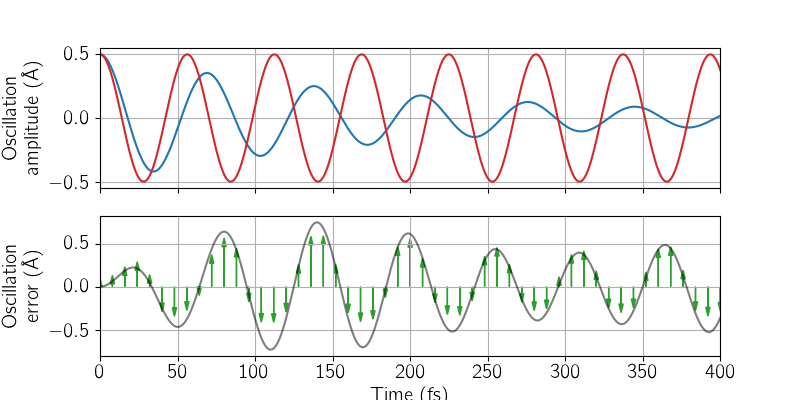

In [8]:
target = Trajectory('target.traj', 'r')
poor = Trajectory('poor.traj', 'r')
db = Debye()

fsteps = int(2000 / 40 + 1)
f = np.zeros((fsteps, 6))
print('Calculating WAXS forces')
ctf = 0
for a, atoms in enumerate(poor):
    if a % 40 == 0:
        s_exp = db.debye(target[a])
        atoms.calc = DebyeCalc(db, s_exp, k=1e-2)
        f[ctf] = atoms.get_forces().flatten()
        ctf += 1
        if ctf % 5 == 0:
            print(f'{ctf * 2:3d} % Done')

f = f.reshape((fsteps, 2, 3))

#### Make the plot
d_target = np.array([atoms.get_distance(0, 1) for atoms in target])
t_target = np.linspace(0, dt * len(d_target), len(d_target))

d_poor = np.array([atoms.get_distance(0, 1) for atoms in poor])
t_poor = np.linspace(0, dt * len(d_poor), len(d_poor))


ncs = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(2, 1, figsize=(8, 4))
ax = axes[0]
ax.plot(t_target, d_target - 1.5, color=ncs[0], label='Real Oscillation')
ax.plot(t_poor, d_poor - 1.5, color=ncs[3], label='Initial Force Constant')
ax.set_xticklabels([])
ax.set_ylabel('Oscillation \n amplitude (Å)')
ax = axes[1]
const = 0.0005 / 1.75
ax.plot(t_target, d_target - d_poor, 'k-', alpha=0.5, label='Distance difference')
for i, (x, y) in enumerate(zip(t_poor[::40], d_poor[::40])):
        dy = (np.abs(f[i, 0, 0]) + np.abs(f[i, 1, 0])) * np.sign(d_target[i * 40] - d_poor[i * 40]) * const
        dx = 0
        ax.arrow(x, 0, dx, dy, ec=ncs[2], head_width=2.75, head_length=0.10, fc=ncs[2])
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Oscillation \n error (Å)')
for ax in axes:
    ax.set_xlim([0, 400])
    ax.grid('both')
    
plt.savefig('plot2.png', bbox_inches='tight')

The blue curve represents the true structures, here as a single trajectory propagated over time. 


The red curve represents the poor structural prediction from the un-enriched MLP (here simply exemplified as a Hookean with a bad spring constant and no damping). 


The green arrows show the amplitude and direction of the XDS-forces, $\mathbf{F}^{xds}$, which will be used to enrich the MLPs.
One possible XDS-MLP central loss function: Force matching with XDS-regularization:


$$
L = \sum_i \left| \left| \nabla \hat{U}(\mathbf{x}_i,  \theta) +  \mathbf{F}^{QM}_i  \right| \right|^2 + \lambda^2 \left| \left| \mathbf{F}^{xds}_i \right| \right|^2. 
$$


Other options for augmenting the MLP with XDS-energies/forces include new descriptor design, different loss function augmentations, transfer learning.